# Respalizer (c). Data analysis (regression).
## Made by Ilya Zakharkin (github.com/izaharkin).

## Natural language processing (sentiment analysis).

### Data: Given data - responses of people on different bank companies (two features - sentiment (text, in russian) and mark (integer, 1 <= mark <= 5).

### Task: We must predict which mark will this person give consider his response.

#### Useful materials:
- scikit-learn example: http://scikit-learn.org/stable/auto_examples/text/document_classification_20newsgroups.html#sphx-glr-auto-examples-text-document-classification-20newsgroups-py
- article for beginners: https://habrahabr.ru/company/mlclass/blog/270591/
- TJ texts classification: https://habrahabr.ru/post/327072/
- MIPT NLP course: https://github.com/canorbal/NLP_MIPT/
- Russian language processing research: http://corpus.leeds.ac.uk/mocky/
- example with nltk: http://streamhacker.com/2012/11/22/text-classification-sentiment-analysis-nltk-scikitlearn/

In [45]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

import sys
import joblib
import _pickle

from sklearn.model_selection import cross_val_score

In [5]:
data = pd.read_csv('./data/responses_dataset.csv')

In [6]:
data.head(5)

,mark,description
0,5,Я имею кредитную карту. Пользуюсь ею длительно...
1,5,"Всем привет! Я в этом банке , как только рухну..."
2,1,Добрый вечер.Был вашим вкладчиком на протяжени...
3,1,Очень разочарована банком ВТБ24. За смс уведом...
4,1,"Отвратительный банк, и обслуживание. 24.11.201..."


In [7]:
new_columns = data.columns.values
new_columns[1] = 'sentiment'
data.columns = new_columns

/usr/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


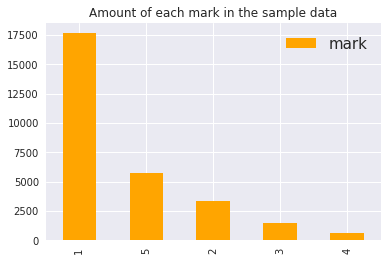

In [8]:
data.mark.value_counts().plot(kind='bar', label='mark', color='orange')
plt.legend(fontsize=15)
plt.title('Amount of each mark in the sample data')

# Regression approach

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score

In [11]:
X = data['sentiment']

vectorizer = TfidfVectorizer(sublinear_tf=True)

%time X = vectorizer.fit_transform(X)
print(X.shape)

CPU times: user 5.22 s, sys: 56.7 ms, total: 5.28 s
Wall time: 5.34 s
(28916, 134520)


In [26]:
y = data['mark']

## 1). Linear models:

In [46]:
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge, RidgeCV

from sklearn.linear_model import ElasticNet
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import LassoLars, Lars

from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model.huber import HuberRegressor 
from sklearn.linear_model import ARDRegression

from sklearn.linear_model import BayesianRidge

Let's see who is **the best among linear models**.   
Let's iterate over all this models and compare them. If we have root_mean_squared_error < 0.5, it will be good, because that means that average error of our model < 0.5, so when we will cast our prediction to the nearest integer number it will be probably the right answer.

In [58]:
models = [SGDRegressor(), LogisticRegression(), Ridge(), 
          Lars(), LassoLars(), PassiveAggressiveRegressor(), OrthogonalMatchingPursuit(),
          HuberRegressor(), ARDRegression(), BayesianRidge()]
# ElasticNet(), TheilSenRegressor()
best_score = -sys.float_info.max
best_estimator = ''
for model in models:
    try:
        cv_scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5)
        cv_mean_score = cv_scores.mean()
        print('{0} has rmse = {1:.4f} +- {2:.4f}'.format(str(model), np.sqrt(-cv_mean_score), cv_scores.std()))
        if cv_mean_score > best_score:
            best_score = cv_mean_score
            best_estimator = str(model)
    except:
        continue

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False) has rmse = 1.5542 +- 0.0573
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) has rmse = 0.9130 +- 0.0378
Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001) has rmse = 0.8672 +- 0.0202
PassiveAggressiveRegressor(C=1.0, epsilon=0.1, fit_intercept=True,
              loss='epsilon_insensitive', n_iter=5, random_state=None,
              shuffle=True, verbose=0, warm_start=False) has rmse = 0.9646 +- 0.0173
HuberRegressor(alpha=0.0001

In [ ]:
print('Best among linear models is {0} with rmse = {1:.4f} +- {2:.4f}'
      .format(str(best_estimator), np.sqrt(-best_score)))

# 2). Ensembles:

In [64]:
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

In [68]:
models = [ExtraTreesRegressor(), RandomForestRegressor()]
# AdaBoostRegressor has rmse = 1.2715 +- 0.0964
# BaggingRegressor(KNeighborsRegressor())
best_score = -sys.float_info.max
best_estimator = ''
for model in models:
    try:
        cv_scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5)
        cv_mean_score = cv_scores.mean()
        print('{0} has rmse = {1:.4f} +- {2:.4f}'.format(str(model), np.sqrt(-cv_mean_score), cv_scores.std()))
        if cv_mean_score > best_score:
            best_score = cv_mean_score
            best_estimator = str(model)
    except TypeError:
        continue

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
          verbose=0, warm_start=False) has rmse = 0.9742 +- 0.0472
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False) has rmse = 0.9922 +- 0.0428
